In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [16]:
# Nombre de particules
N = 500

Q = 1 # Variance du modèle 
R = 20 # Variance des observations
# longueur de scénario
T = 50

x_init = np.random.normal()

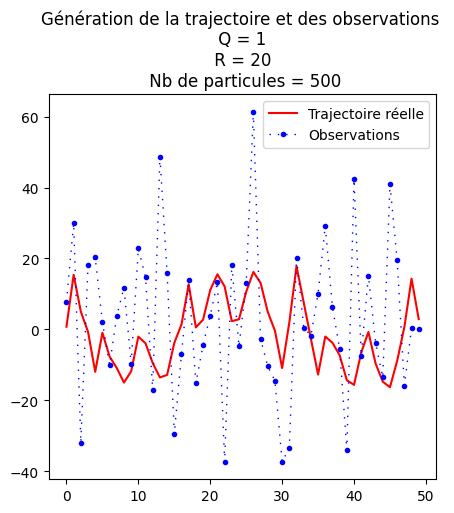

In [17]:
# Main function pool

def f(x, n):
    return 0.5*x + 25*(x/(1+x**2)) + 8*np.cos(1.2*n)

def g(x):
    return (x**2)/20
# Hidden states + observations generation
def generate_hidden_states(Q, T, x_init):
    X = np.zeros(T)
    X[0] = x_init
    for i in range(0, len(X) -1):
        X[i+1] = f(X[i], i+1) + np.random.normal(0, Q)
    return X

def generate_observations(R, T, X):
    Y = np.zeros(T)
    for i in range(len(Y) -1):
        Y[i] = g(X[i]) + np.random.normal(0, R)
    return Y


X_RW = generate_hidden_states(Q, T, x_init)
Y = generate_observations(R, T, X_RW)

plt.figure(figsize=(5, 5))
plt.plot(X_RW, color="r", label='Trajectoire réelle')
plt.plot(Y, color="b", linestyle=(0, (1, 5)), marker='o', markersize=3, label='Observations', linewidth='1')
plt.legend()
plt.title(f"Génération de la trajectoire et des observations \n Q = {Q} \n R = {R} \n Nb de particules = {N}")
plt.show()

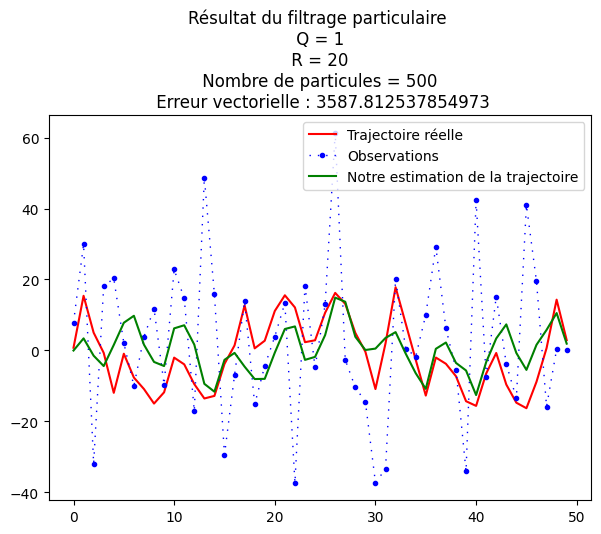

In [18]:
def filtrage_particulaire(W, X, reech, y_n, Q, R, t):
    # Tirage des nouvelles particules
    X = np.hstack((X, f(reech, t).reshape(-1, 1) + np.random.normal(0, Q, (N, 1)) ))
    # Calcul de la vraisemblance de chaque particule
    W = np.hstack( (W, stats.norm.pdf(y_n, g(X[:, -1]).reshape(-1, 1), R)) )
    # Calcul du poids normalisé de chaque particule
    W[:, -1] = W[:, -1] / W[:, -1].sum()
    return W, X

# Ici :
#   - X sont les particules
#   - Y les observations (tableau de (T))
#   - W les poids

# On initialise X_0 avec les n particules :
X = np.random.randn(N, 1)
W = stats.norm.pdf(Y[0], g(X[:, -1]).reshape(-1, 1), R)
W[:, -1] = W[:, -1] / W[:, -1].sum()

# On propage:
for t in range(1, T):
    # On simule selon les poids pour rééchantilloner nos particules
    A = np.random.choice(range(N), N, p=W[:, -1])
    # rééchantillonage de X (des particules)
    reech = X[:,-1][A]
    # Nouvelle étape de filtrage particulaire
    W, X = filtrage_particulaire(W, X, reech, Y[t], Q, R, t)

# On sommes les poids pondérés pour avoir l'estimation par filtrage particulaire
filtrage = (X * W).sum(0)


def erreur_quad(X, Y):
    sum = 0
    T = len(X)
    for i in range(T):
        sum += (X[i] - Y[i])**2
    return sum

err = erreur_quad(X_RW, filtrage)


plt.figure(figsize=(7, 5))
plt.plot(X_RW, color="r", label='Trajectoire réelle')
plt.plot(Y, color="b", linestyle=(0, (1, 5)), marker='o', markersize=3, label='Observations', linewidth='1')
plt.plot(filtrage, color="g", label="Notre estimation de la trajectoire")
plt.legend()
plt.title(
        f"Résultat du filtrage particulaire \n Q = {Q} \n R = {R} \n Nombre de particules = {N} \n Erreur vectorielle : {err}")
plt.show()